/tmp/ipykernel_83734/2186964822.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['avg_rewards'] = (data_filtered['rewards_agent_0'] + data_filtered['rewards_agent_1']) / 2
/tmp/ipykernel_83734/2186964822.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['avg_rewards'] = (data_filtered['rewards_agent_0'] + data_filtered['rewards_agent_1']) / 2
/tmp/ipykernel_83734/2186964822.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

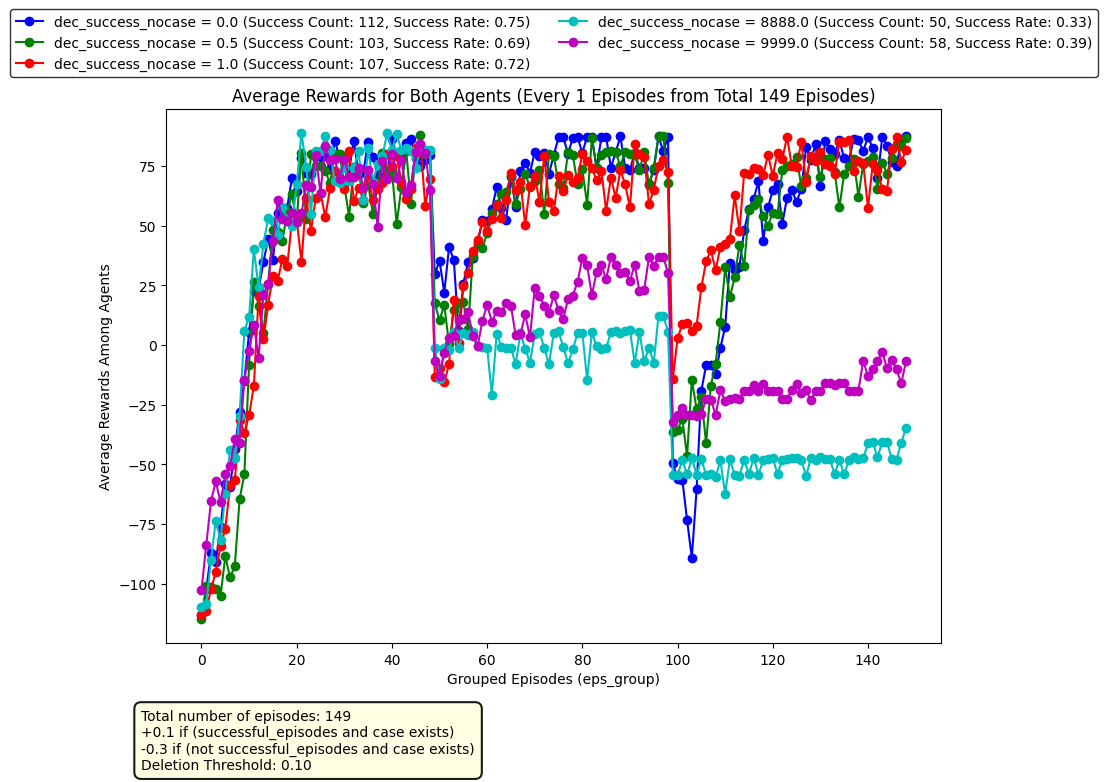

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder path containing CSV files in the current directory
folder_path = './d-del/'

# Variable to control how many episodes to average together
episodes_per_average = 1

# Initialize an empty list to hold data from all files
all_data_frames = []

# Loop through all CSV files in the specified folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        # Load the data from the CSV file and append to the list
        df = pd.read_csv(file_path)
        df['filename'] = filename  # Add a filename column to keep track of source
        all_data_frames.append(df)

# If no CSV files are found, exit without generating the graph
if len(all_data_frames) == 0:
    print("No CSV files found in the specified folder.")
else:
    # Concatenate all data frames into a single data frame
    combined_data = pd.concat(all_data_frames, ignore_index=True)

    # Request user input for dec_unsuccess filtering
    dec_unsuccess_filter = float(input("Enter the value for dec_unsuccess (99 for no filter): "))

    # Apply filter for dec_unsuccess, if it's not 99
    if dec_unsuccess_filter != 99:
        combined_data = combined_data[combined_data['dec_unsuccess'] == dec_unsuccess_filter]

    # Create a new column for grouping episodes in batches
    combined_data['eps_group'] = (combined_data['eps'] // episodes_per_average) * episodes_per_average

    # Group by 'eps_group' and 'dec_success_nocase', then calculate the average values for numeric columns only
    grouped_data = combined_data.groupby(['eps_group', 'dec_success_nocase']).mean(numeric_only=True).reset_index()

    # Find unique values of 'dec_success_nocase' for coloring different lines
    unique_dec_success_nocase_values = grouped_data['dec_success_nocase'].unique()

    # Calculate the success count and total number of episodes for each `dec_success_nocase` value
    success_count = combined_data[combined_data['eps_status'] == 1].groupby(['dec_success_nocase', 'filename']).size().reset_index(name='success_count')
    total_episodes_info = combined_data[['dec_success_nocase', 'eps', 'filename']].drop_duplicates().groupby(['dec_success_nocase', 'filename']).size().reset_index(name='total_episodes')

    # Merge success count and total episodes, and then summarize for each dec_success_nocase value
    success_info = pd.merge(success_count, total_episodes_info, on=['dec_success_nocase', 'filename'])
    success_info_summary = success_info.groupby('dec_success_nocase').agg({
        'success_count': 'sum',
        'total_episodes': 'sum',
        'filename': 'nunique'
    }).reset_index()

    # Rename 'filename' to 'num_similar_files' for clarity
    success_info_summary.rename(columns={'filename': 'num_similar_files'}, inplace=True)

    # Calculate the success count by dividing by the number of similar files
    success_info_summary['success_count'] = success_info_summary['success_count'] / success_info_summary['num_similar_files']

    # Calculate the success rate using the previous method (total success count divided by total episodes without averaging by similar files)
    success_info_summary['success_rate'] = success_info_summary['success_count'] * success_info_summary['num_similar_files'] / success_info_summary['total_episodes']

    # Plot: Average Rewards for Both Agents Across All Episodes
    plt.figure(figsize=(10, 6))

    # Define a set of colors to use for different lines
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plot the average rewards for each `dec_success_nocase` value
    for i, dec_value in enumerate(unique_dec_success_nocase_values):
        # Filter the data for the current `dec_success_nocase` value
        data_filtered = grouped_data[grouped_data['dec_success_nocase'] == dec_value]
        # Calculate average rewards among agents
        data_filtered['avg_rewards'] = (data_filtered['rewards_agent_0'] + data_filtered['rewards_agent_1']) / 2
        # Extract the success rate and count for the current `dec_success_nocase` value
        count = success_info_summary[success_info_summary['dec_success_nocase'] == dec_value]['success_count'].values[0]
        rate = success_info_summary[success_info_summary['dec_success_nocase'] == dec_value]['success_rate'].values[0]
        # Plot the line for the current `dec_success_nocase` value
        plt.plot(data_filtered['eps_group'], data_filtered['avg_rewards'], label=f'dec_success_nocase = {dec_value} (Success Count: {count:.0f}, Success Rate: {rate:.2f})', color=colors[i % len(colors)], marker='o')

    # Set chart title and labels
    total_episodes = combined_data['eps'].nunique()
    plt.title(f"Average Rewards for Both Agents (Every {episodes_per_average} Episodes from Total {total_episodes} Episodes)")
    plt.xlabel('Grouped Episodes (eps_group)')
    plt.ylabel('Average Rewards Among Agents')

    # Place the legend above the plot area without overlapping, with a border
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, frameon=True, edgecolor='black')

    # Extract non-graphical data for display (averaged across all files)
    non_graphical_data = grouped_data[['inc_success', 'dec_unsuccess', 'del_threshold']].mean().to_dict()

    # Combine all additional formatted information into one text block, including the number of episodes
    legend_text = (
        f"Total number of episodes: {combined_data['eps'].nunique()}\n"
        f"+{non_graphical_data['inc_success']:.1f} if (successful_episodes and case exists)\n"
        f"-{non_graphical_data['dec_unsuccess']:.1f} if (not successful_episodes and case exists)\n"
        f"Deletion Threshold: {non_graphical_data['del_threshold']:.2f}"
    )

    # Add the combined formatted information below the plot with a single enhanced box and adjust positioning closer to the plot
    props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow', alpha=0.9, linewidth=1.5)
    plt.figtext(0.1, -0.1, legend_text, fontsize=10, ha='left', bbox=props)

    # Adjust layout to prevent overlap and add extra space for the legend at the top
    plt.subplots_adjust(top=1)  # Adjusted the top margin to ensure there's no extra space between the legend and plot

    # Show the plot
    plt.show()
